Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


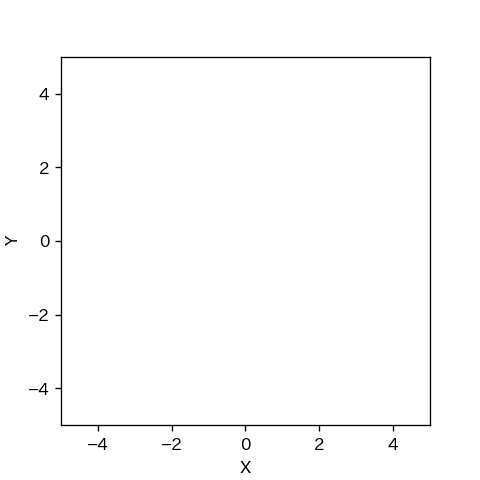

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


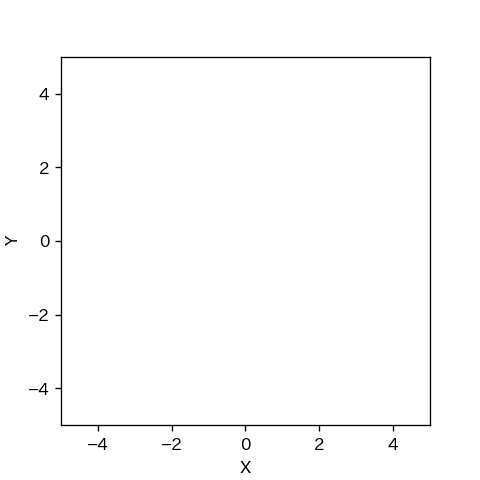

(array([-3.43312305, -1.48267681,  1.90344725]),
 array([-1.04456606, -2.2346527 , -0.9580002 ]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.1747937630020795]
0 真値: [5.90286409 2.42190867 3.63474589] 推定値: [ 1.73886586  5.64939924 -0.4291171 ] 誤差: 5.268356159732335
[3.0867808341197596]
1 真値: [4.91678487 3.88932088 3.31853142] 推定値: [ 4.0091768   4.93918961 -2.28977155] 誤差: 1.3877956486930116
[6.533147403524011]
2 真値: [ 2.92993598 -2.62302841  2.37438376] 推定値: [ 7.08557056  8.36562105 -1.47629597] 誤差: 11.748179257170332
[6.336181425144506]
3 真値: [-2.52399948 -4.05330539  8.41512021] 推定値: [-0.70384019  0.66813845  0.80830195] 誤差: 5.060139507471801
[5.915567570022483]
4 真値: [-2.79659029 -1.10921713  6.54274409] 推定値: [-2.55378878 -0.72268031  6.34436737] 誤差: 0.4564682817173558
1
[4.751392274157353]
5 真値: [4.8674062  3.68868554 4.06039872] 推定値: [4.63199944 3.20940438 3.83164659] 誤差: 0.5339726339071942
2
[3.5618704029061]
6 真値: [-1.47084181  1.71272775  6.0410736 ] 推定値: [-1.52896502  1.77293702 -0.2913572 ] 誤差: 0.08368669667867461
3
[2.596908192413391]
7 真値: [ 2.07916583 -4.21374094  7.91465631] 推定値: [ 1.45978206 -2.06718489 -1.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.7077249428945196]
20 真値: [ 1.73935303 -4.19826015  7.68363478] 推定値: [ 3.10845911 -3.8809444   2.49863441] 誤差: 1.405397009337011
21 真値: [-1.680962    5.56178904  4.77264875] 推定値: [-2.08343378  4.93236105  4.75572123] 誤差: 0.7471031554955162
9
[1.1512361301165577]
22 真値: [-2.90538819  3.43496393  3.826133  ] 推定値: [-3.21282405  3.50608238  3.94959401] 誤差: 0.3155544968142066
10
[5.784054681520486]
23 真値: [ 4.0435172  -2.30862185  8.22238378] 推定値: [ 4.24709931 -2.4315179   8.25382712] 誤差: 0.23780057990199727
11
[1.0417769832382378]
24 真値: [ 3.29394524 -1.01269545  3.43177808] 推定値: [ 3.48867458 -1.03268182  3.30718198] 誤差: 0.19575231876072996
12
[5.069924966968356]
25 真値: [-3.95543234 -0.05288908  4.98312438] 推定値: [-3.87139176  0.30786229  4.72709583] 誤差: 0.3704110849917495
13
26 真値: [-3.46478749 -0.02208657  6.70422856] 推定値: [ 2.93598414 -5.69107304  6.84362365] 誤差: 8.55027982186224
[3.7169254779905323]
[6.0007892307519395]
[3.9283200466058585, 4.1778287052960295]
27 真値: [ 4.86004915 -0.3